# Optimal buffer zone width
To limit gravity edge effects, many inversions use a buffer zone to extend the model beyond the extent of the gravity data. This limits the edge effects to the portion of the model outside the area of interest. A large buffer zone results is smaller errors in the area of interest, but the larger model can lead to significantly slower runtime of the code. Here we show a method to choose the optimal buffer zone width to limit edge effects, but not significantly slow down the inversion.

The edge effects are due to the contrast between the edge of the model and the void space beyond. The larger and/or denser the prisms near the edge, the large the contrast with the void space will be and thus the larger the edge effects will be.

## Import packages

In [45]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import verde as vd
import xarray as xr
import xrft
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

from invert4geom import optimization, synthetic, utils

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define model parameters

In [2]:
spacing = 1000
region = (0, 40000, 0, 30000)
zref = 0
density_contrast = 2670
gravity_obs_height = 1e3

## Calculate gravity without a buffer zone
Here we will load synthetic topography data, create a layer of adjacent vertical right-rectangular prisms, and calculate the forward gravity effect for the entire region of the prism layer (i.e. without a buffer zone). This will result in a noticeable gravity edge effect, where there is a decay of observed gravity values towards the edges of the model. 

In [54]:
# load synthetic topography data
topography, _, _, _ = synthetic.load_synthetic_model(
    spacing=spacing,
    region=region,
    number_of_constraints=10,
    plot_topography_diff=False,
)

INFO:invert4geom:RMSE at the constraints between the starting and true topography: 19.262348539866753 m


In [55]:
# prisms above zref have positive density contrast and prisms below zref have
# negative density contrast
density_grid = xr.where(
    topography >= zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
prisms = utils.grids_to_prisms(
    topography,
    zref,
    density=density_grid,
)

# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=gravity_obs_height,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

# calculate gravity anomaly
grav_df["gravity_anomaly"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=False,
)
# convert from dataframe to dataarray
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray().gravity_anomaly

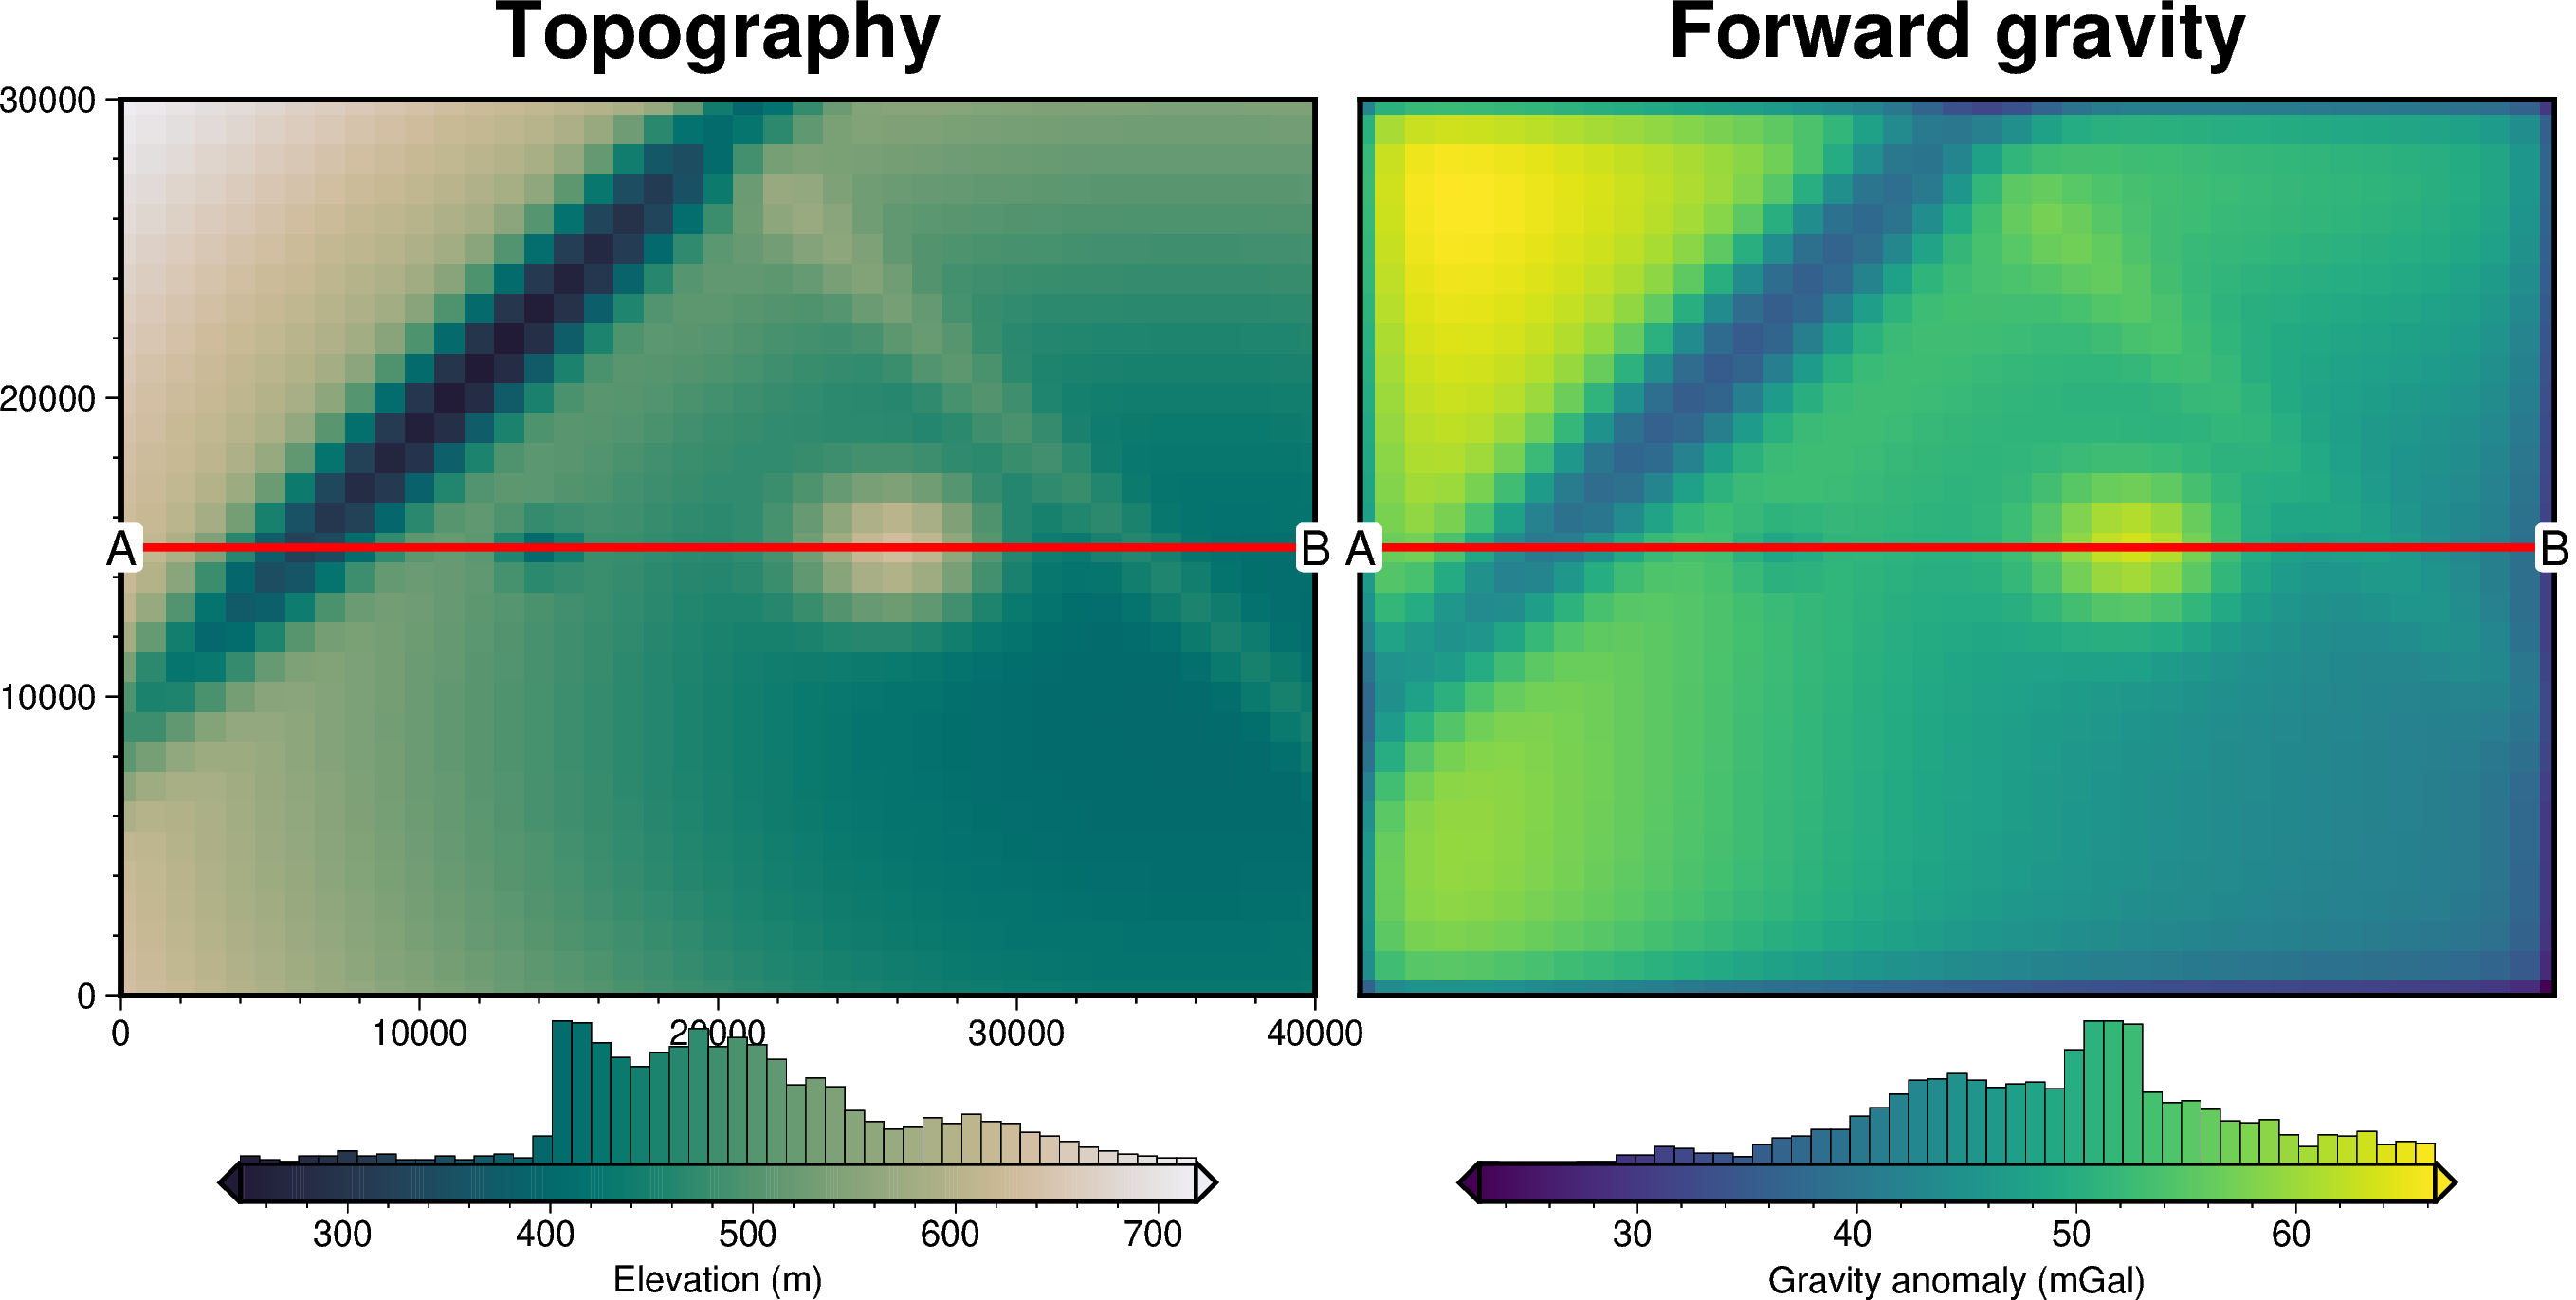

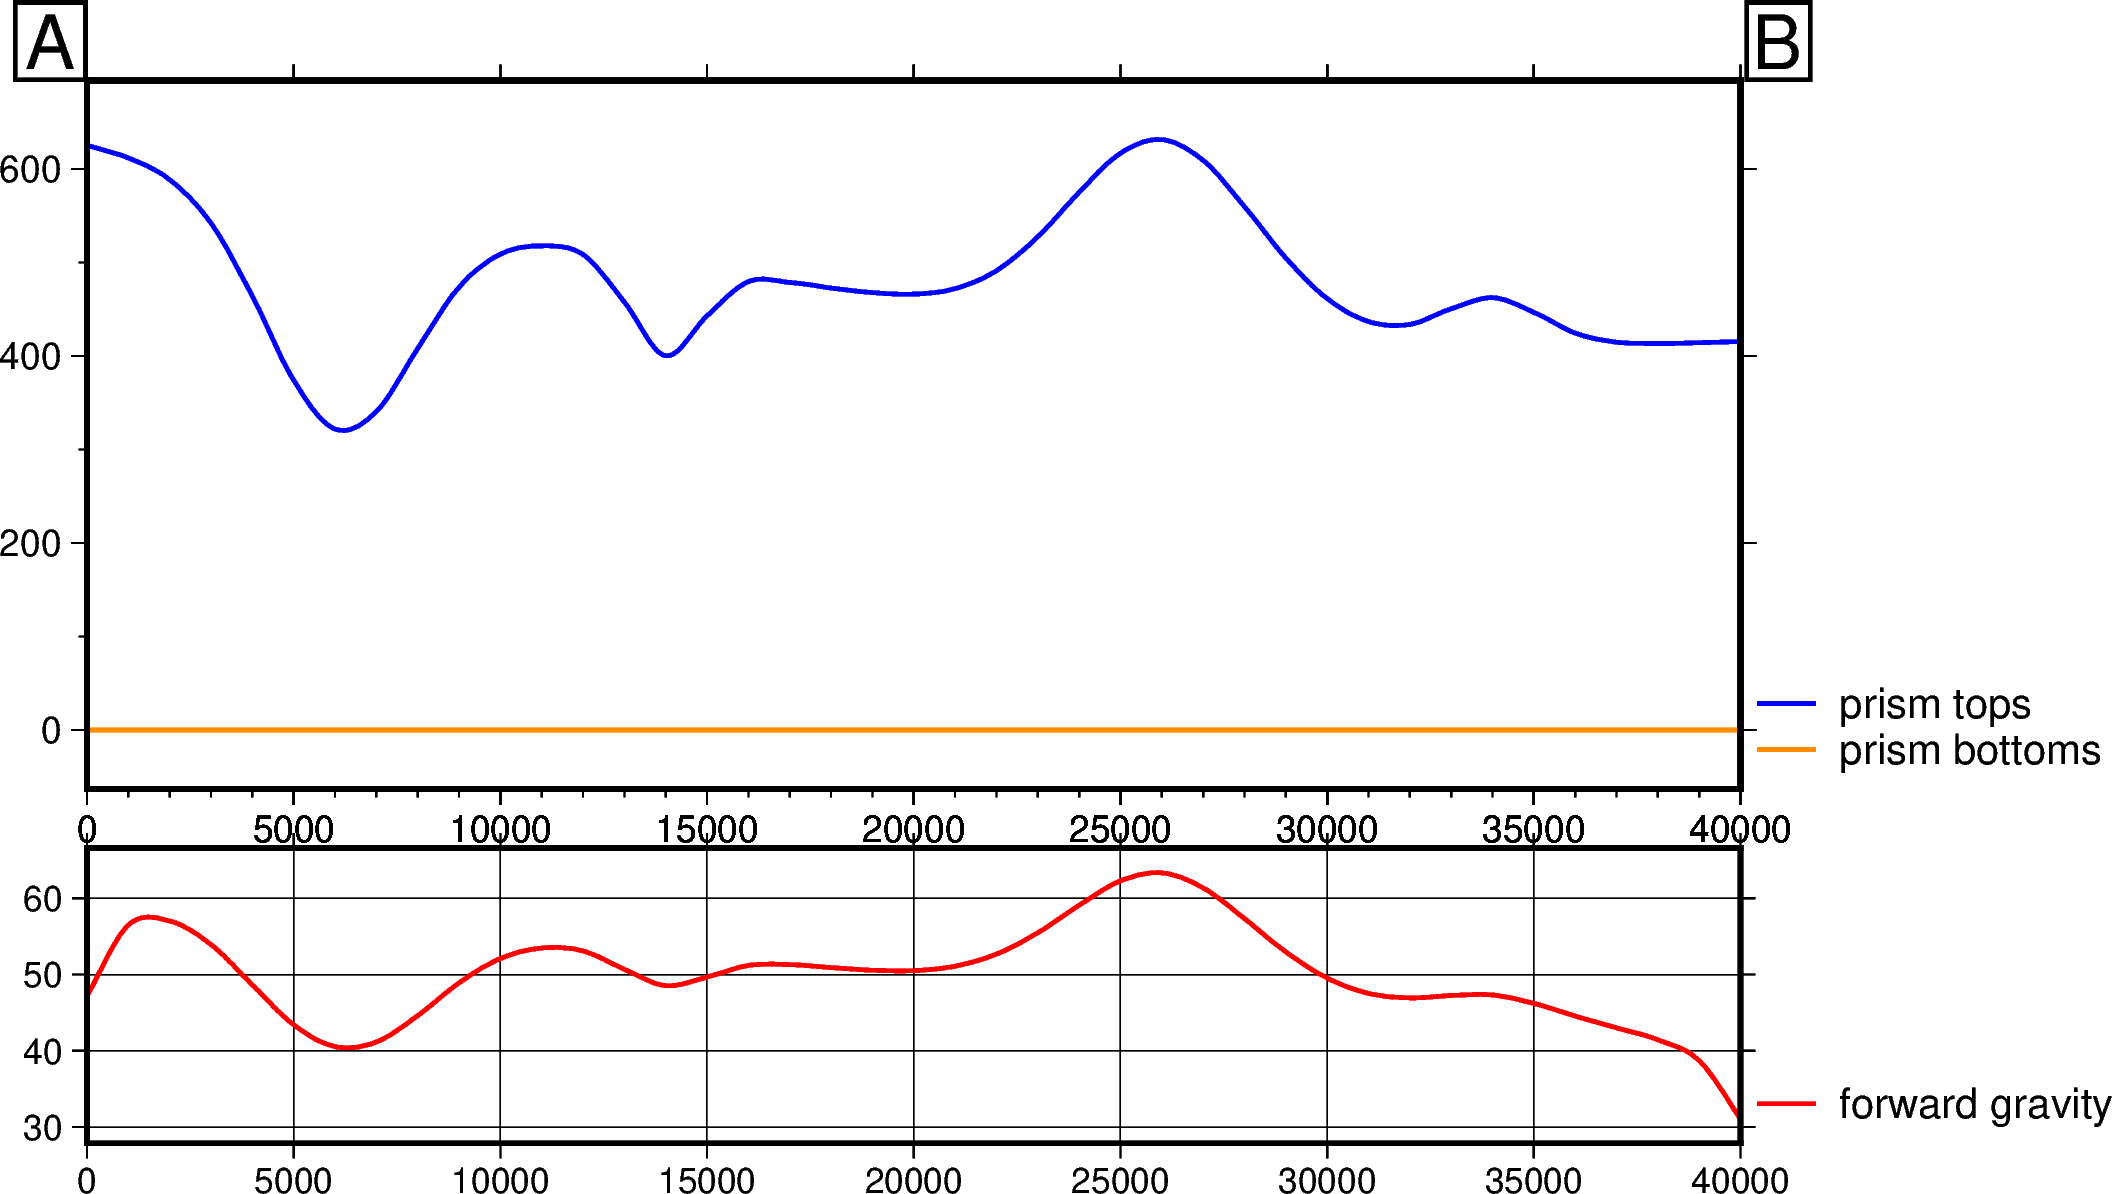

In [56]:
# profile start and stop locations
start = (region[0], (region[3] - region[2]) / 2)
stop = (region[1], (region[3] - region[2]) / 2)

# plot topography
fig = maps.plot_grd(
    topography,
    fig_height=8,
    hist=True,
    title="Topography",
    cbar_label="Elevation (m)",
    reverse_cpt=True,
    cmap="rain",
    frame=True,
)
# plot profile location, and endpoints on map
fig.plot(
    x=[start[0], stop[0]],
    y=[start[1], stop[1]],
    pen="2p,red",
)
fig.text(
    x=start[0],
    y=start[1],
    text="A",
    fill="white",
    font="12p,Helvetica,black",
    justify="CM",
    clearance="+tO",
    no_clip=True,
)
fig.text(
    x=stop[0],
    y=stop[1],
    text="B",
    fill="white",
    font="12p,Helvetica,black",
    justify="CM",
    clearance="+tO",
    no_clip=True,
)

# plot gravity anomaly
fig = maps.plot_grd(
    grav_grid,
    fig=fig,
    origin_shift="x",
    hist=True,
    title="Forward gravity",
    cbar_label="Gravity anomaly (mGal)",
)
# plot profile location, and endpoints on map
fig.plot(
    x=[start[0], stop[0]],
    y=[start[1], stop[1]],
    pen="2p,red",
)
fig.text(
    x=start[0],
    y=start[1],
    text="A",
    fill="white",
    font="12p,Helvetica,black",
    justify="CM",
    clearance="+tO",
    no_clip=True,
)
fig.text(
    x=stop[0],
    y=stop[1],
    text="B",
    fill="white",
    font="12p,Helvetica,black",
    justify="CM",
    clearance="+tO",
    no_clip=True,
)
fig.show()

# plot profile across region
data_dict = profiles.make_data_dict(
    ["forward gravity"],
    [grav_grid],
    ["red"],
)

layers_dict = profiles.make_data_dict(
    ["prism tops", "prism bottoms"],
    [prisms.top, prisms.bottom],
    ["blue", "darkorange"],
)

fig, _, _ = profiles.plot_profile(
    "points",
    start=start,
    stop=stop,
    layers_dict=layers_dict,
    data_dict=data_dict,
    fill_layers=False,
)
fig.show()

## Quantify edge effects
Here we show a technique for trying to quantify edge effects. We create a prism layer which represents a simplistic version of our true prism layer which will be used in the inversion. This simple layer of prisms will have flat tops and bottoms, and constant density values. These values should represent the mean values of the true prism model. We then calculate the forward gravity effect of these prisms across an `inner_region` which represents our area of interest. A buffer zone can be set as a percentage of region width. Since the prisms are flat, the maximum gravity value will be in the center of the prism layer and the gravity values will decay towards the edges of the region of interest as the edge effect increases. The gravity decay can be estimated as the percentile difference between the maximum and minimum gravity values in the region of interest.

To represent our prism layer we want to use in the inversion (from above cells), we use the same zref, the mean topography for the top values, and the same density contrast values.

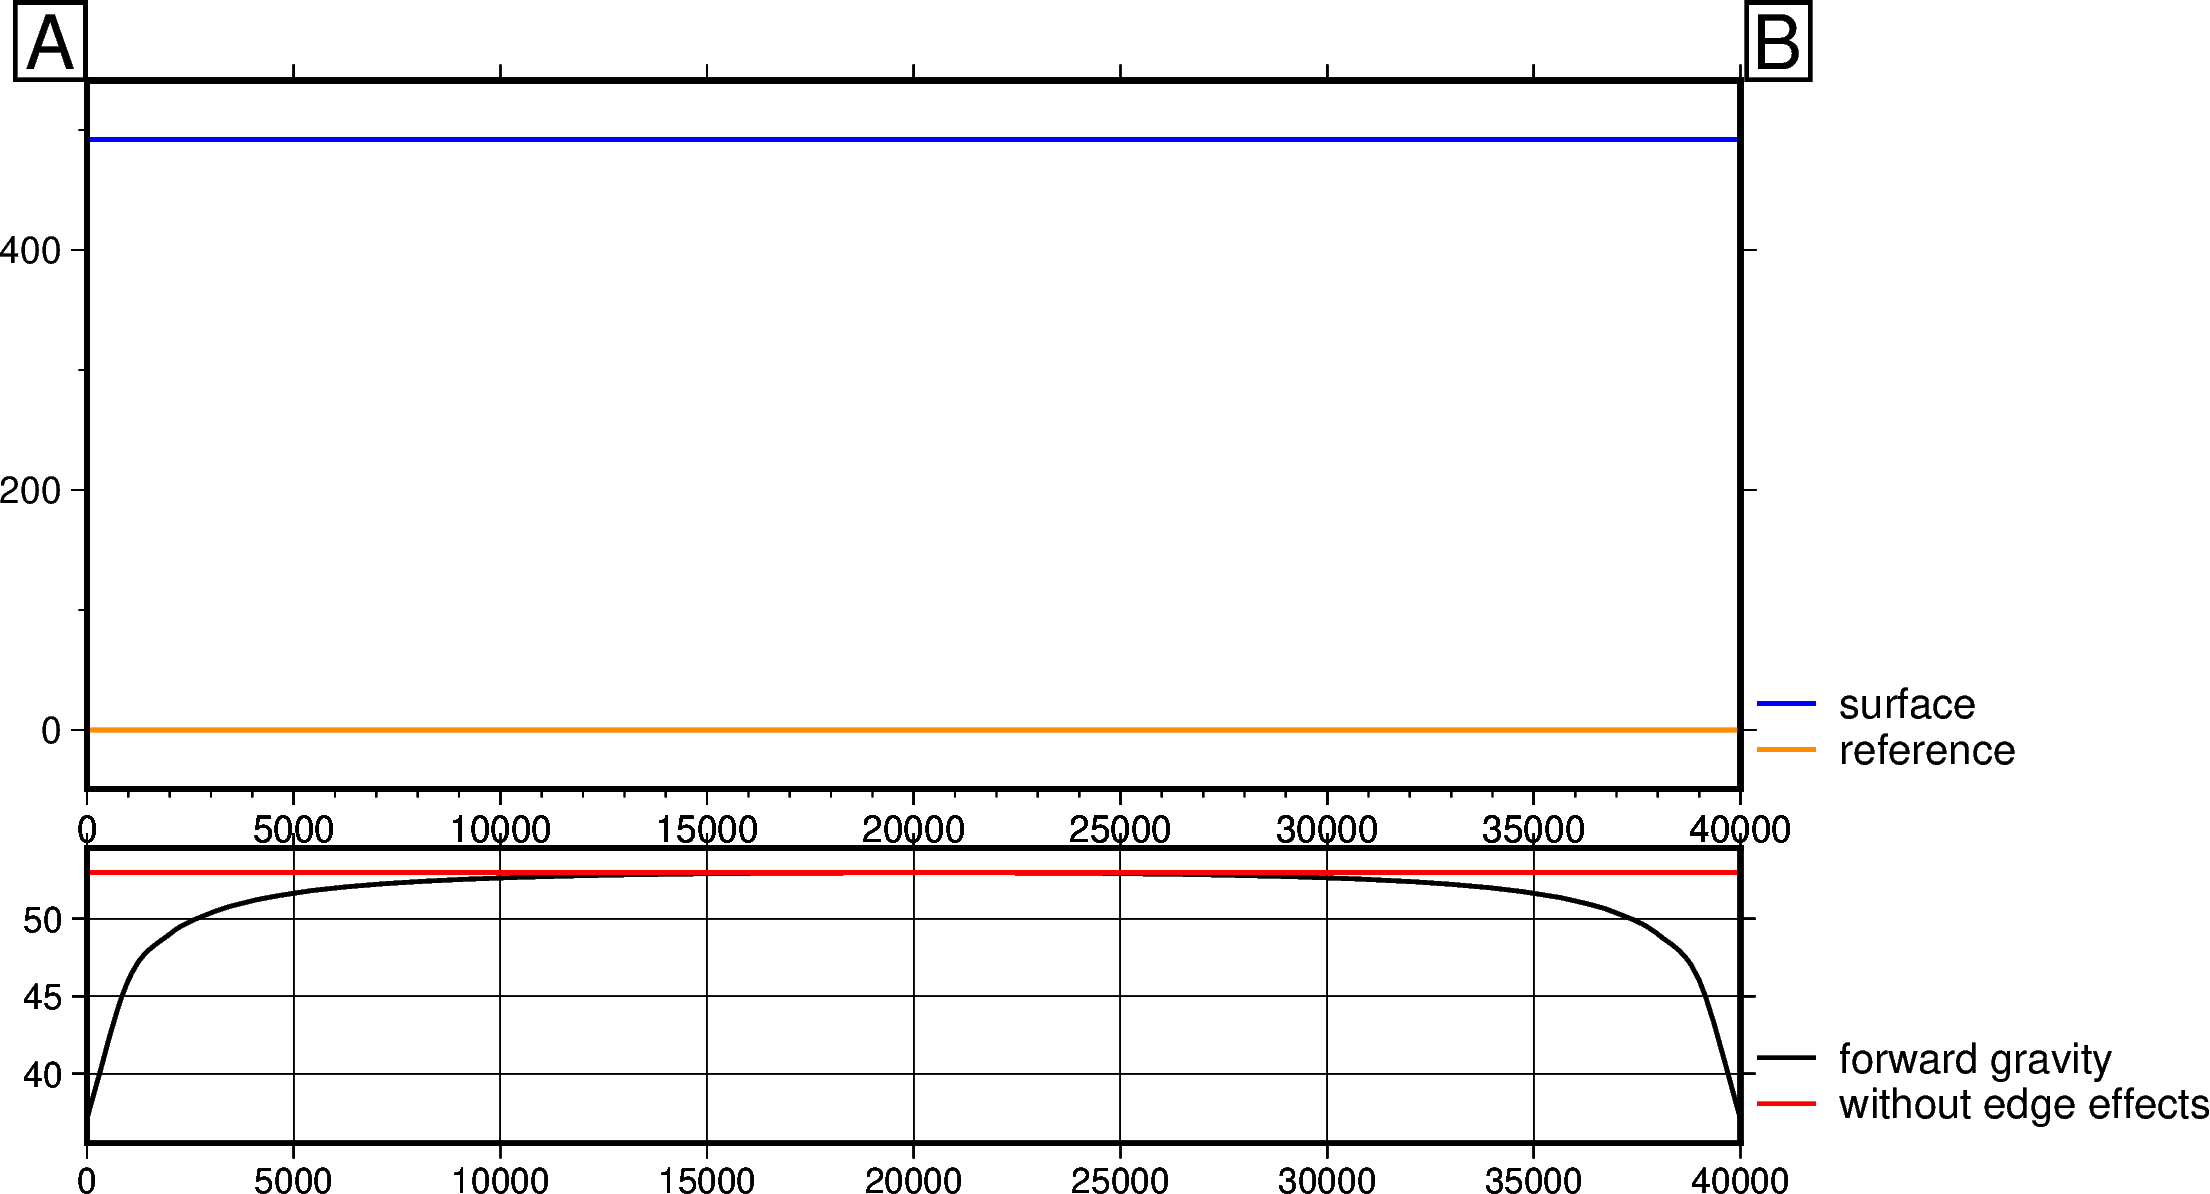

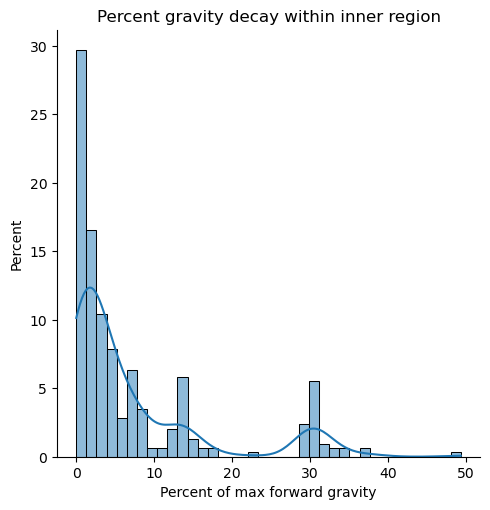

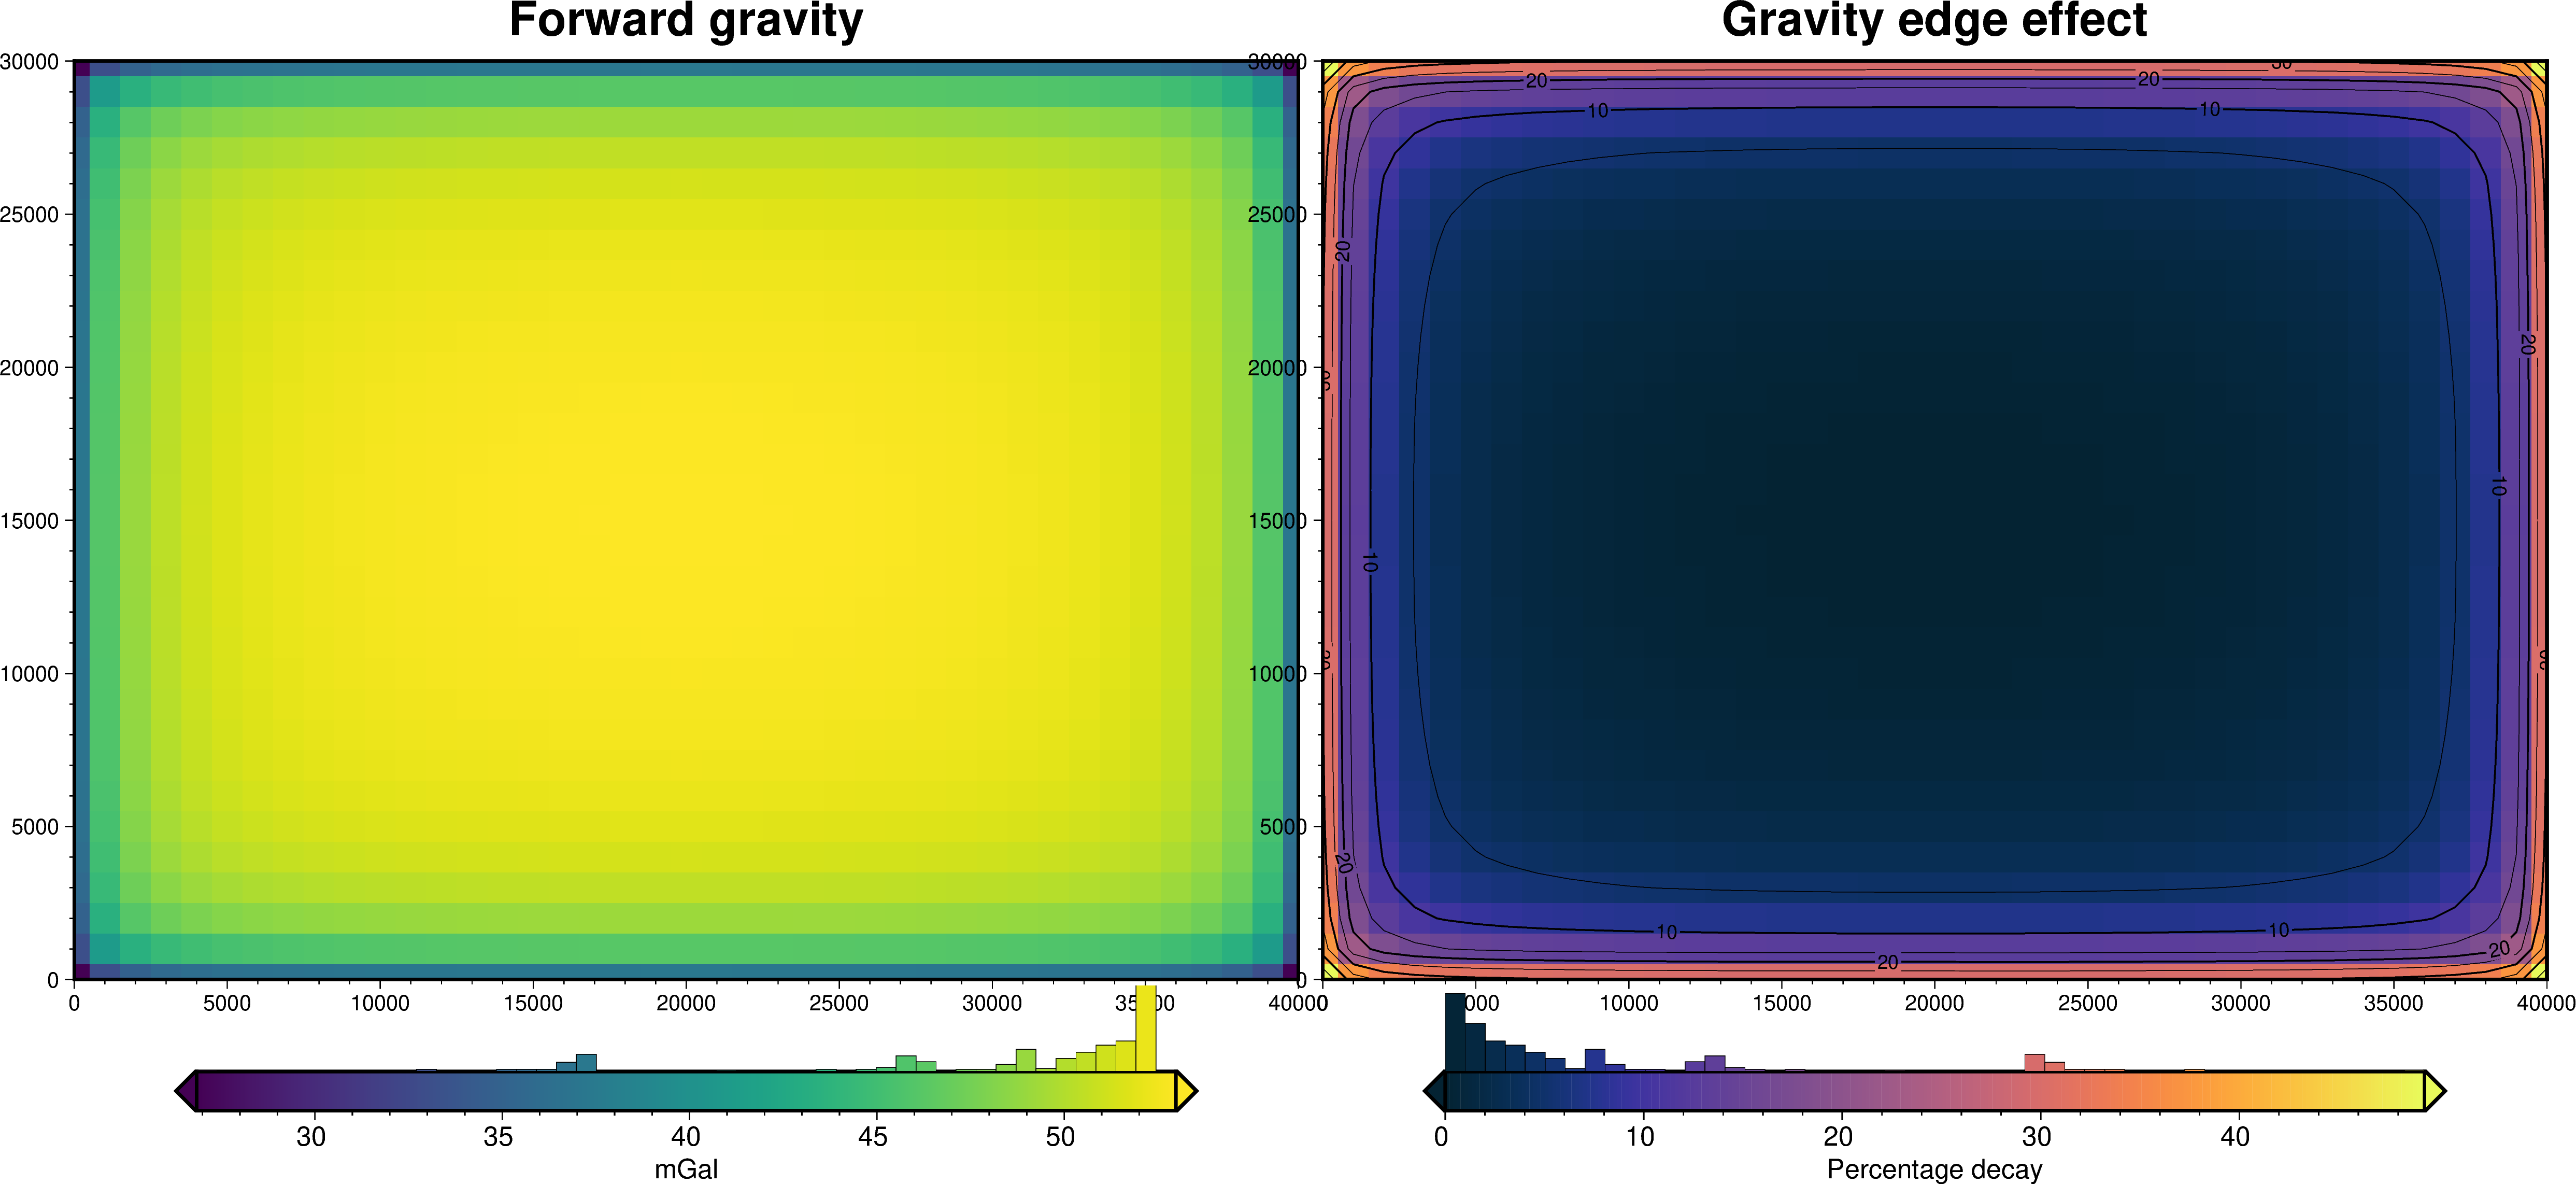

In [57]:
max_decay, _, _, _ = utils.gravity_decay_buffer(
    buffer_perc=0,
    obs_height=gravity_obs_height,
    top=topography.values.mean(),
    zref=zref,
    spacing=spacing,
    inner_region=region,
    density=density_contrast,
)

In [58]:
print(f"Max decay: {round(max_decay, 1)}%")

Max decay: 49.3%


As you can see above, the technique for estimating the gravity decay (edge effects) works pretty well. For this scenario, with no buffer zone, the maximum amount of decay is 50%. This would introduce significant errors into the inversion. Below we demonstrate how to choose the optimal buffer zone width.

## Find optimal buffer zone width
We can run an optimization on a range of buffer zone widths and find the value which gets us closest to set amount of gravitational decay. This set amount of decay is chosen with `target`. High values will result in a small buffer zone (inversions will run faster), but will include noticable edge effects at the model edge. Conversely, small values will results in large buffer zones (slowing down the code), but will limit edge effects. Here we use a target of 3% decay. The optimization will test 20 values of buffer zone widths between 1% and 100% of the region width.

Do estimate the gravity decay, we create a flat layer of prisms and calculate it's forward gravity. The max value is then compared to the edge values to determine the amount of decay. Use the parameters `inner_region`, `spacing`, `top`, `zref` and `density` to mimic your inversion model as closely as possible.

  0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:Current trial (#8, {'buffer_perc': 5.164526997029019}) has a worse score (10.29496600938845) than either of the lower (2.4993016741285707) or upper (2.709799752841776) parameter value limits, it might be best to stop the study and expand the limits.
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 7
INFO:invert4geom:	parameter: {'buffer_perc': 18.087769674065417}
INFO:invert4geom:	scores: [0.2329733223640531]


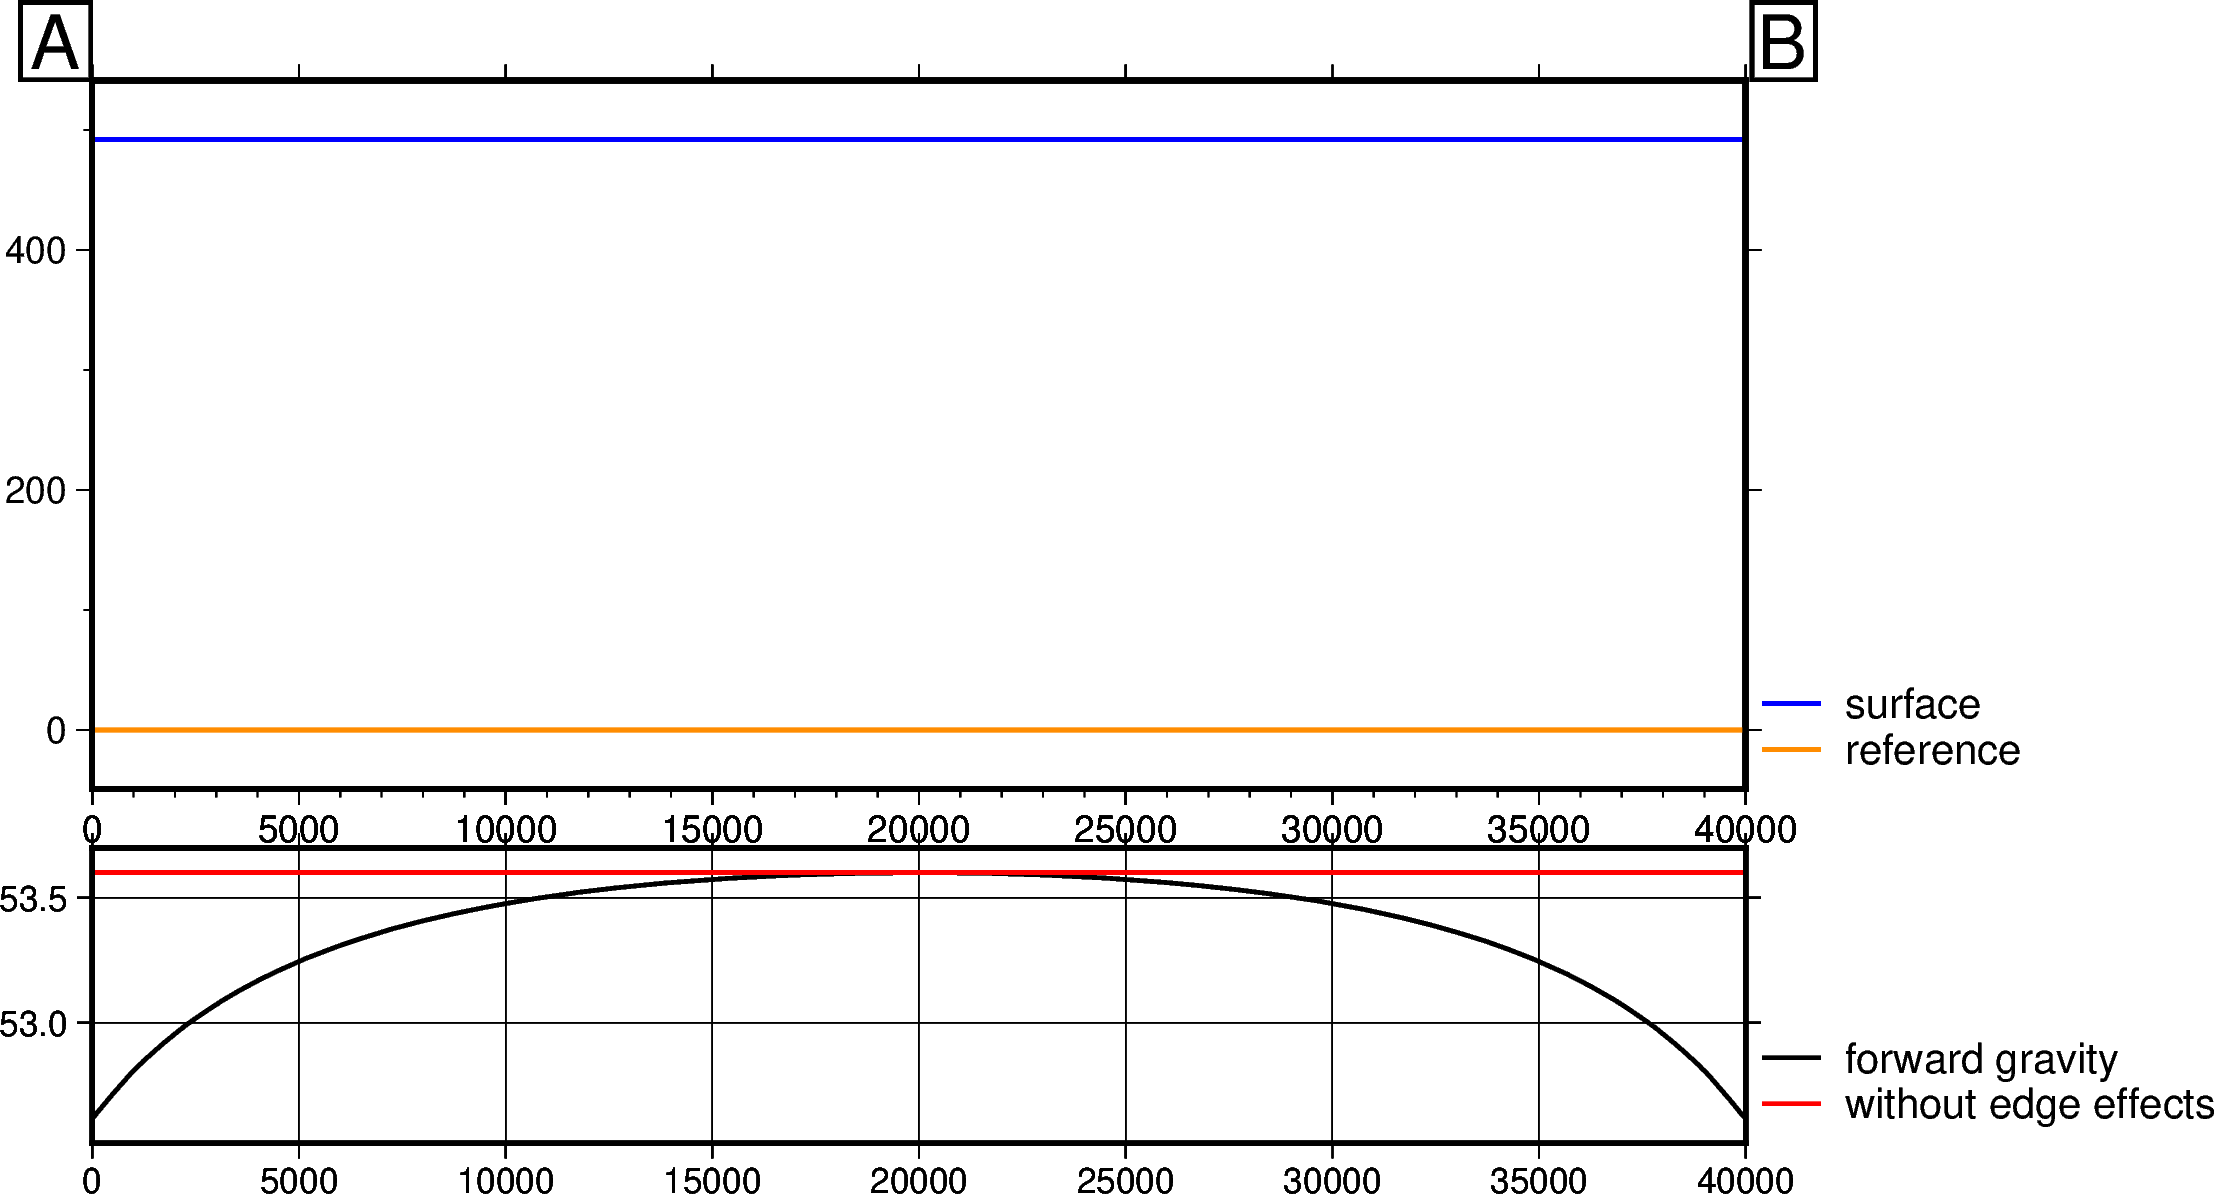

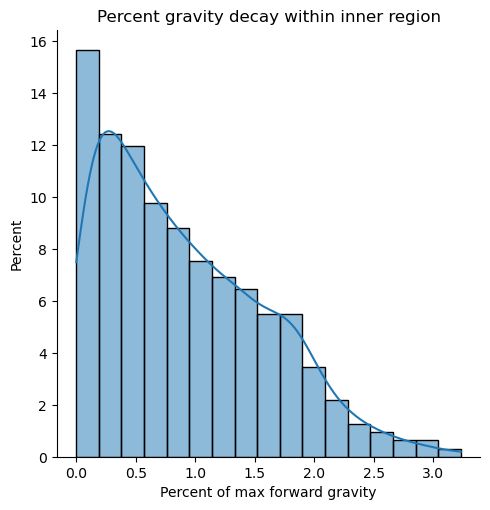

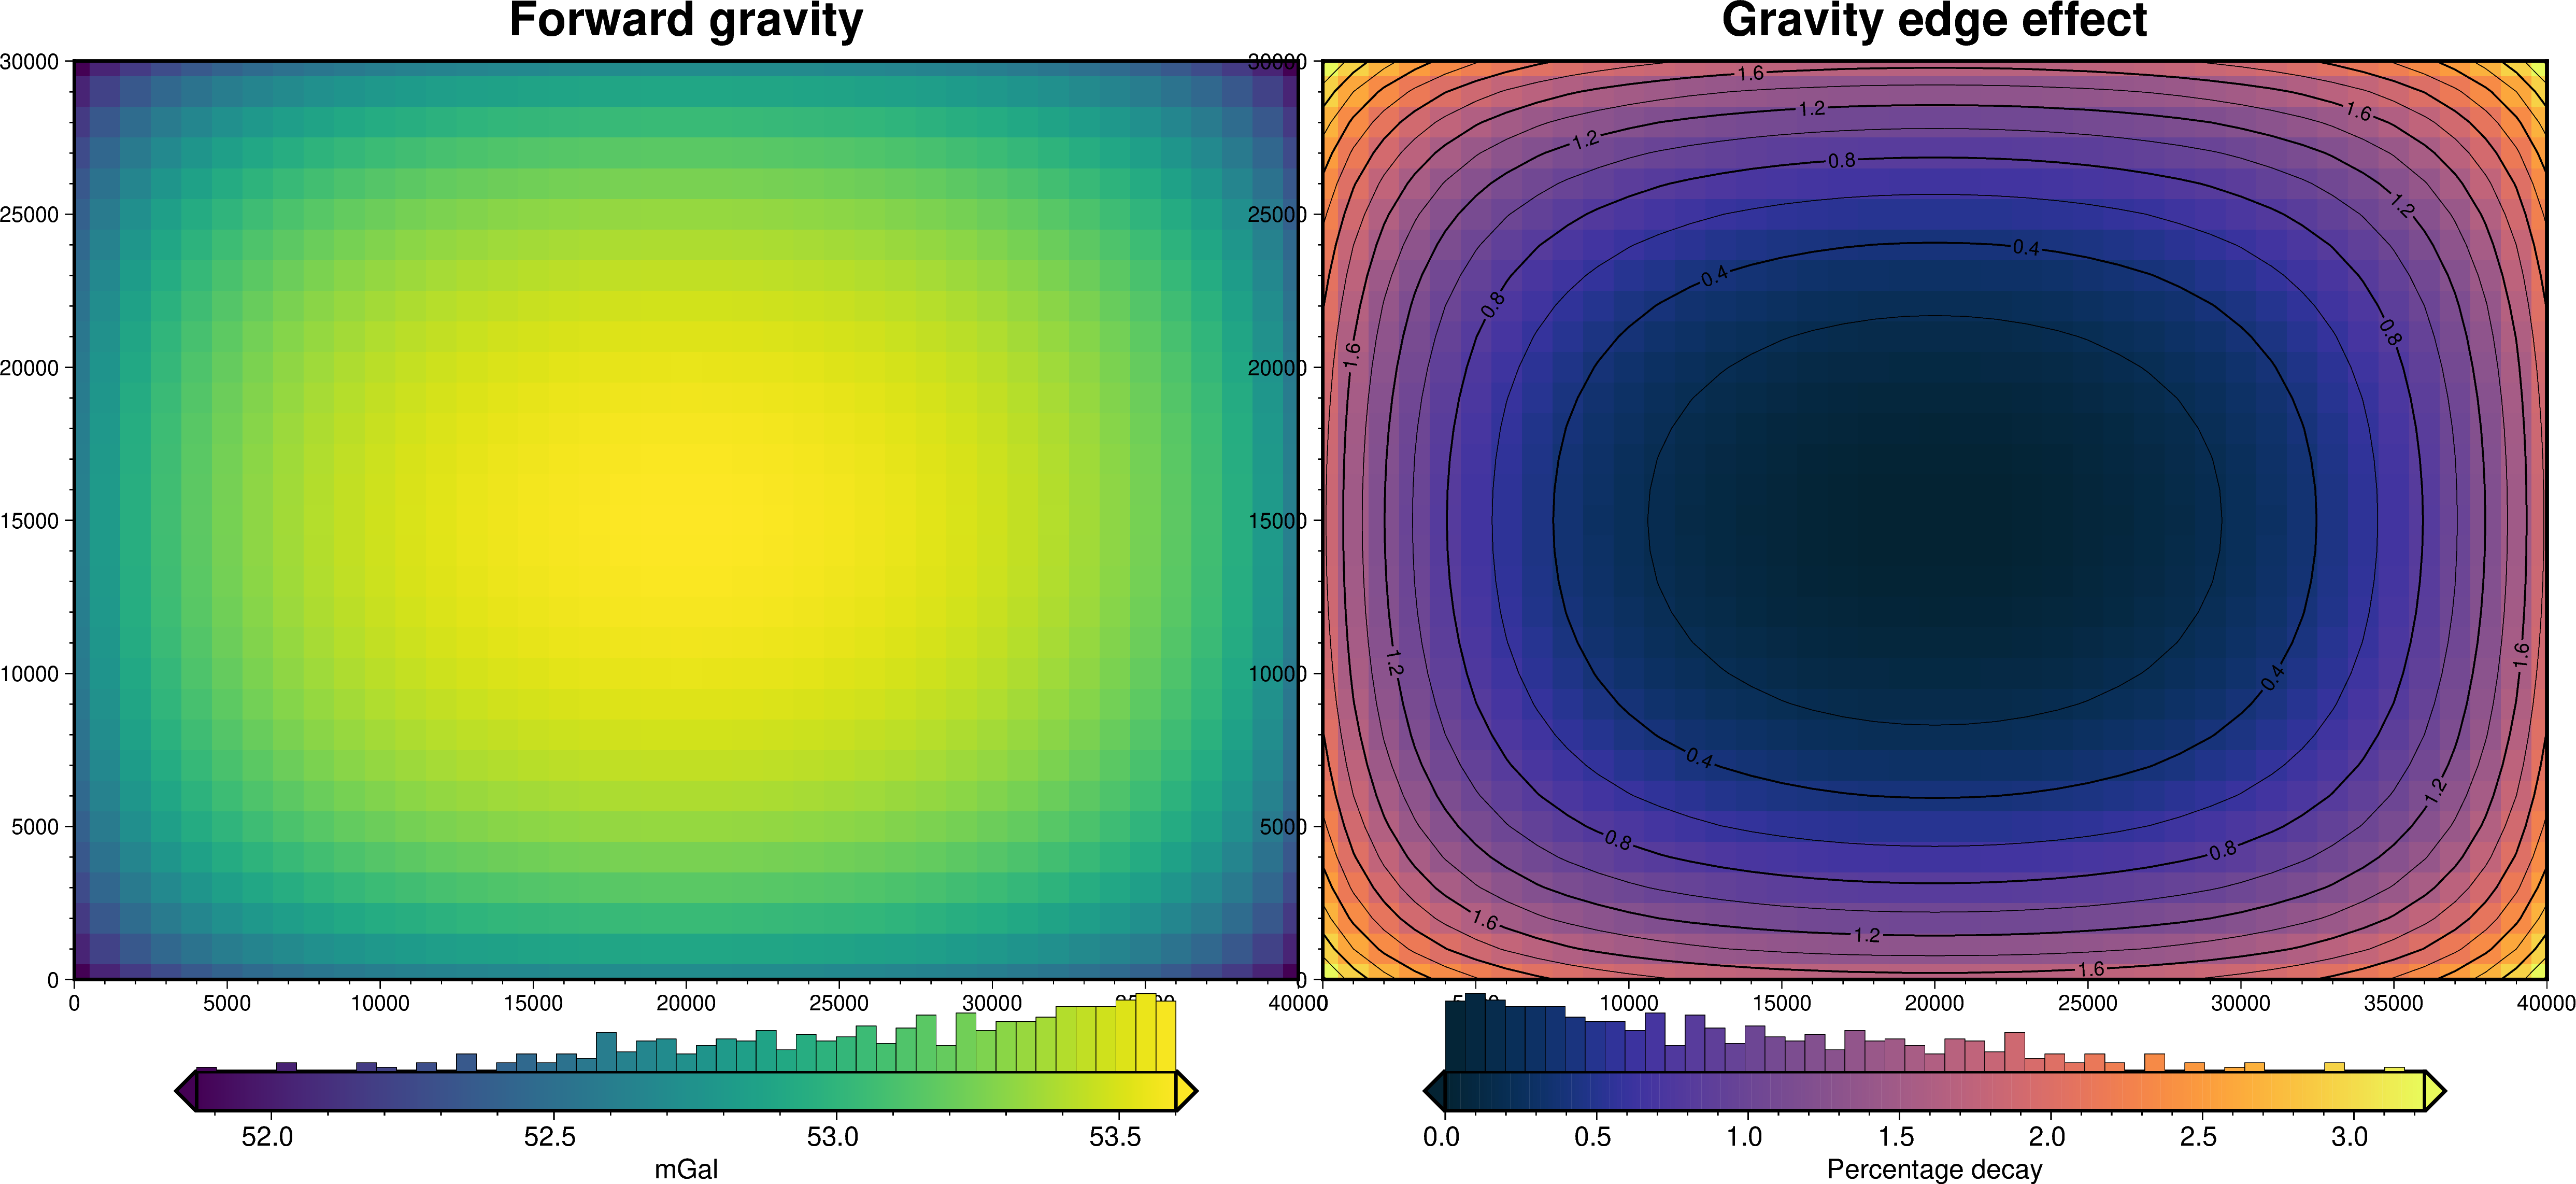

In [59]:
study, results = optimization.optimal_buffer(
    target=3,
    buffer_perc_limits=[1, 100],
    n_trials=20,
    obs_height=gravity_obs_height,
    top=topography.values.mean(),
    zref=zref,
    spacing=spacing,
    inner_region=region,
    density=density_contrast,
)
_, buffer_width, buffer_cells, _ = results

In [60]:
print(f"Optimal buffer width: {buffer_width/1e3} km")
print(f"Optimal number of buffer cells: {buffer_cells}")

Optimal buffer width: 7.0 km
Optimal number of buffer cells: 7


## Use the optimal buffer width
We will recalculate the forward gravity of the topography, but adding a buffer zone with the width determined above. If you're using real topography data, you can just use a grid which is larger by the amount of the buffer zone instead of padding the grid.

In [61]:
# pad to extent of buffer region
pad_width = {
    "northing": buffer_cells,
    "easting": buffer_cells,
}
buffer_topography = xrft.pad(
    topography,
    pad_width,
    mode="linear_ramp",
    constant_values=None,
    end_values=topography.median(),
)

In [63]:
density_grid = xr.where(
    buffer_topography >= zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
prisms = utils.grids_to_prisms(
    buffer_topography,
    zref,
    density=density_grid,
)

# calculate gravity anomaly
grav_df["gravity_anomaly_buffer"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=False,
)
# convert from dataframe to dataarray
grav_grid_buffer = (
    grav_df.set_index(["northing", "easting"]).to_xarray().gravity_anomaly_buffer
)

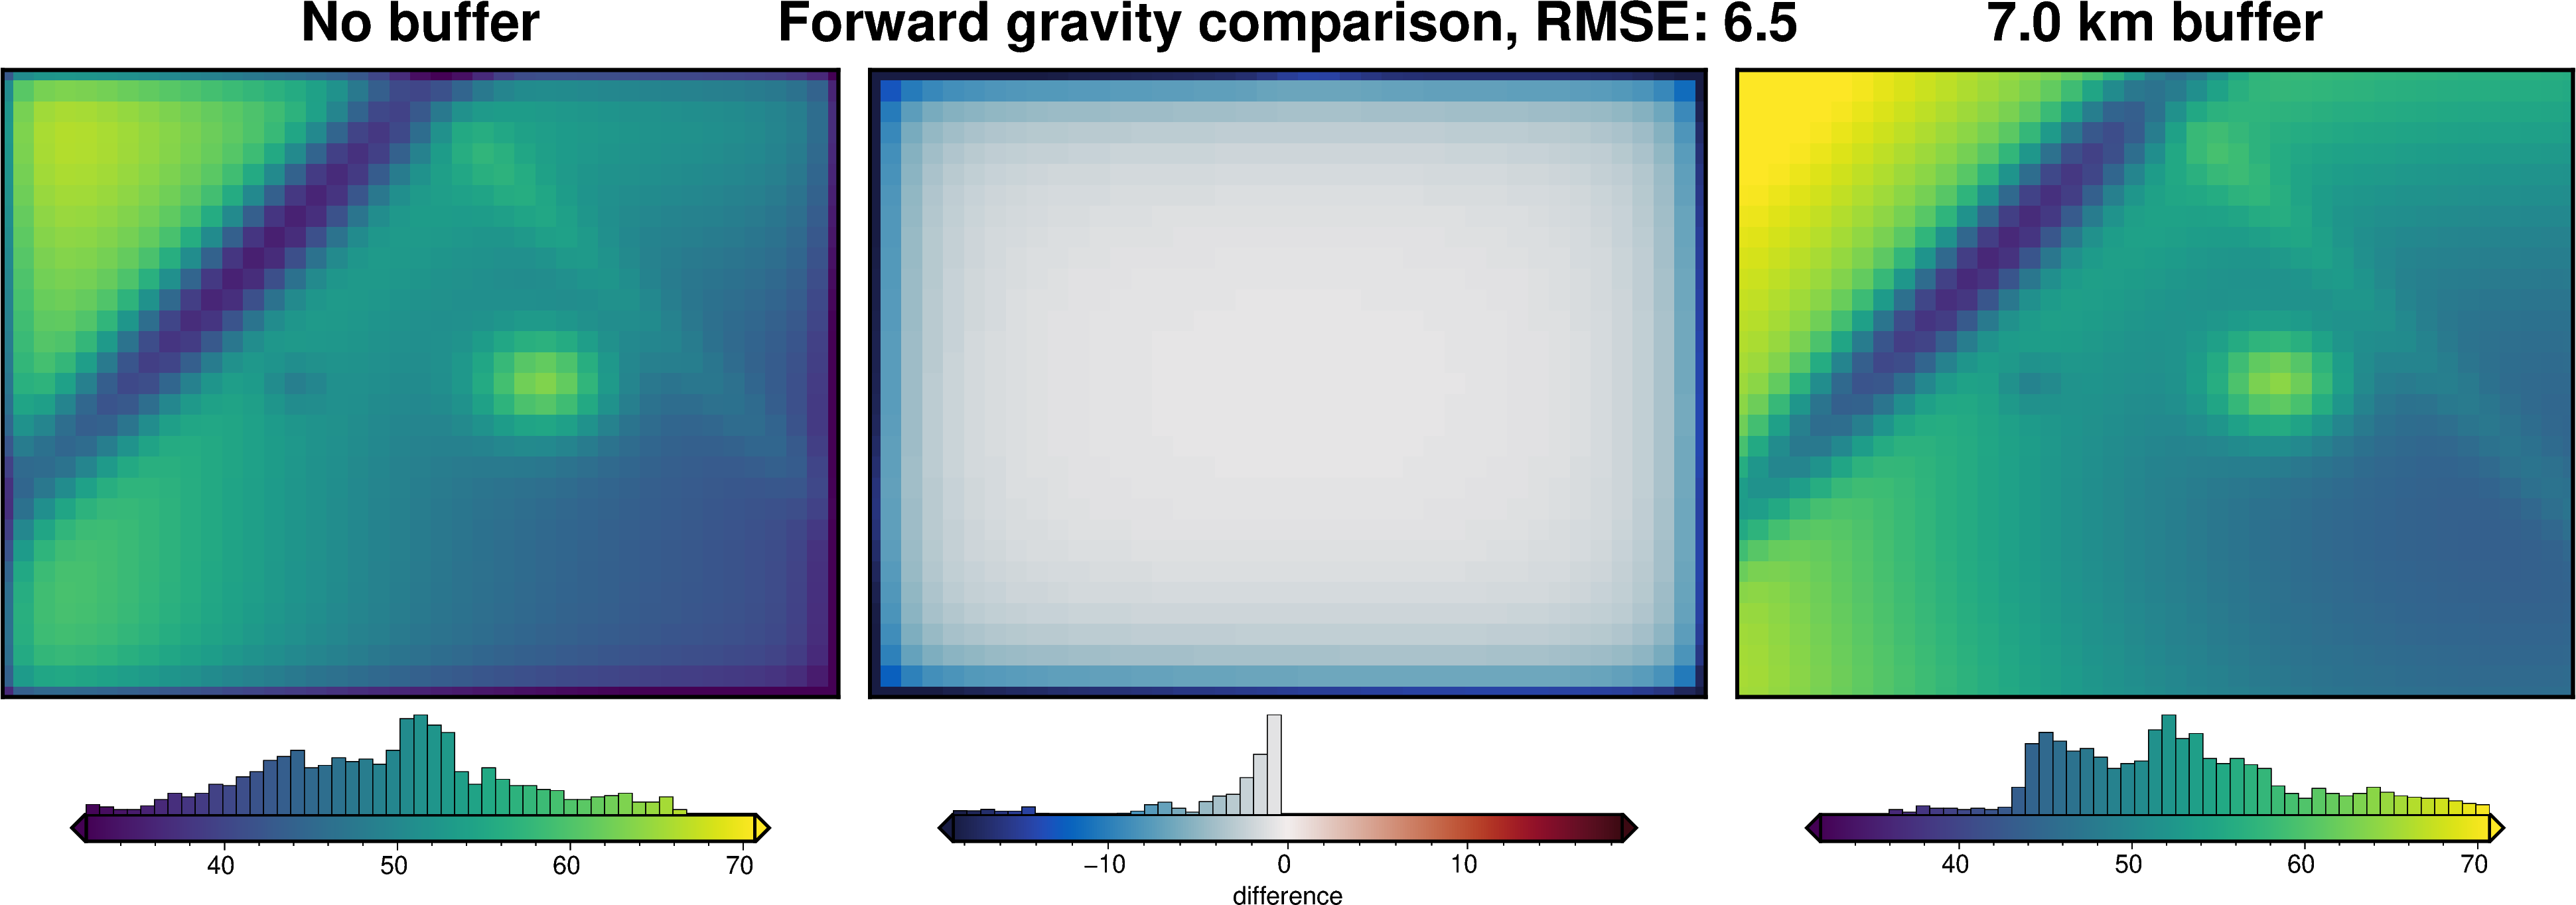

In [66]:
_ = polar_utils.grd_compare(
    grav_grid,
    grav_grid_buffer,
    title="Forward gravity comparison",
    grid1_name="No buffer",
    grid2_name=f"{buffer_width/1e3} km buffer",
    fig_height=8,
    hist=True,
    plot=True,
    inset=False,
    coast=False,
    robust=True,
)

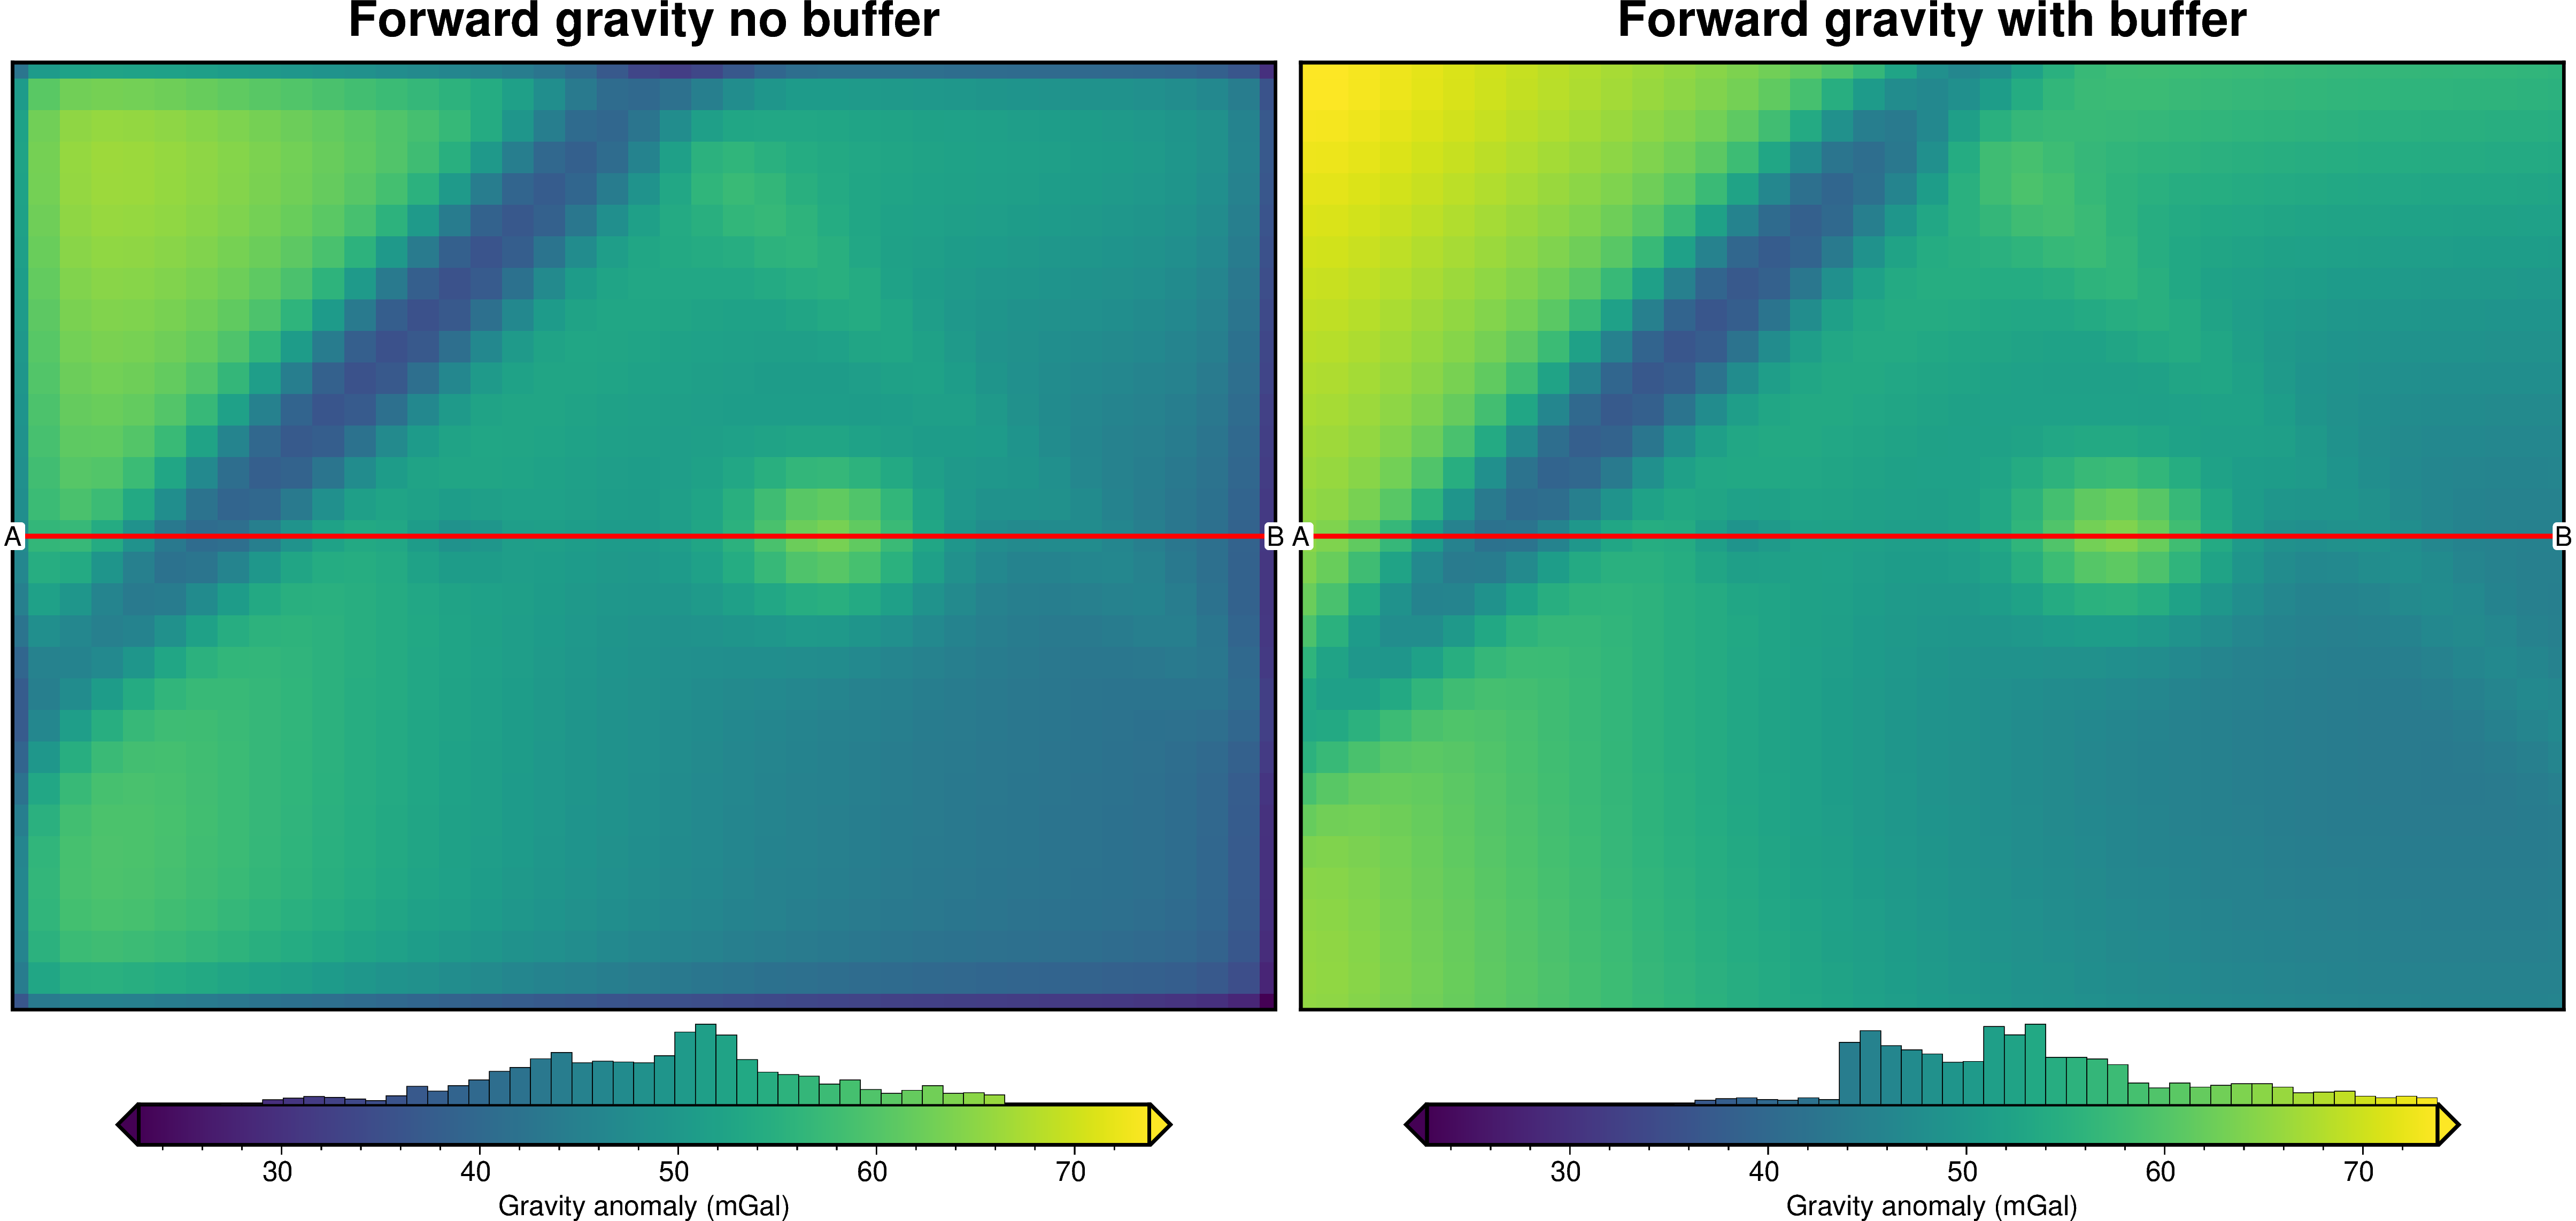

In [76]:
# profile start and stop locations
start = (region[0], (region[3] - region[2]) / 2)
stop = (region[1], (region[3] - region[2]) / 2)

cpt_lims = polar_utils.get_combined_min_max([grav_grid, grav_grid_buffer])

# plot topography
fig = maps.plot_grd(
    grav_grid,
    hist=True,
    cpt_lims=cpt_lims,
    title="Forward gravity no buffer",
    cbar_label="Gravity anomaly (mGal)",
)
# plot profile location, and endpoints on map
fig.plot(
    x=[start[0], stop[0]],
    y=[start[1], stop[1]],
    pen="2p,red",
)
fig.text(
    x=start[0],
    y=start[1],
    text="A",
    fill="white",
    font="12p,Helvetica,black",
    justify="CM",
    clearance="+tO",
    no_clip=True,
)
fig.text(
    x=stop[0],
    y=stop[1],
    text="B",
    fill="white",
    font="12p,Helvetica,black",
    justify="CM",
    clearance="+tO",
    no_clip=True,
)

# plot gravity anomaly
fig = maps.plot_grd(
    grav_grid_buffer,
    fig=fig,
    origin_shift="x",
    cpt_lims=cpt_lims,
    hist=True,
    title="Forward gravity with buffer",
    cbar_label="Gravity anomaly (mGal)",
)
# plot profile location, and endpoints on map
fig.plot(
    x=[start[0], stop[0]],
    y=[start[1], stop[1]],
    pen="2p,red",
)
fig.text(
    x=start[0],
    y=start[1],
    text="A",
    fill="white",
    font="12p,Helvetica,black",
    justify="CM",
    clearance="+tO",
    no_clip=True,
)
fig.text(
    x=stop[0],
    y=stop[1],
    text="B",
    fill="white",
    font="12p,Helvetica,black",
    justify="CM",
    clearance="+tO",
    no_clip=True,
)
fig.show()

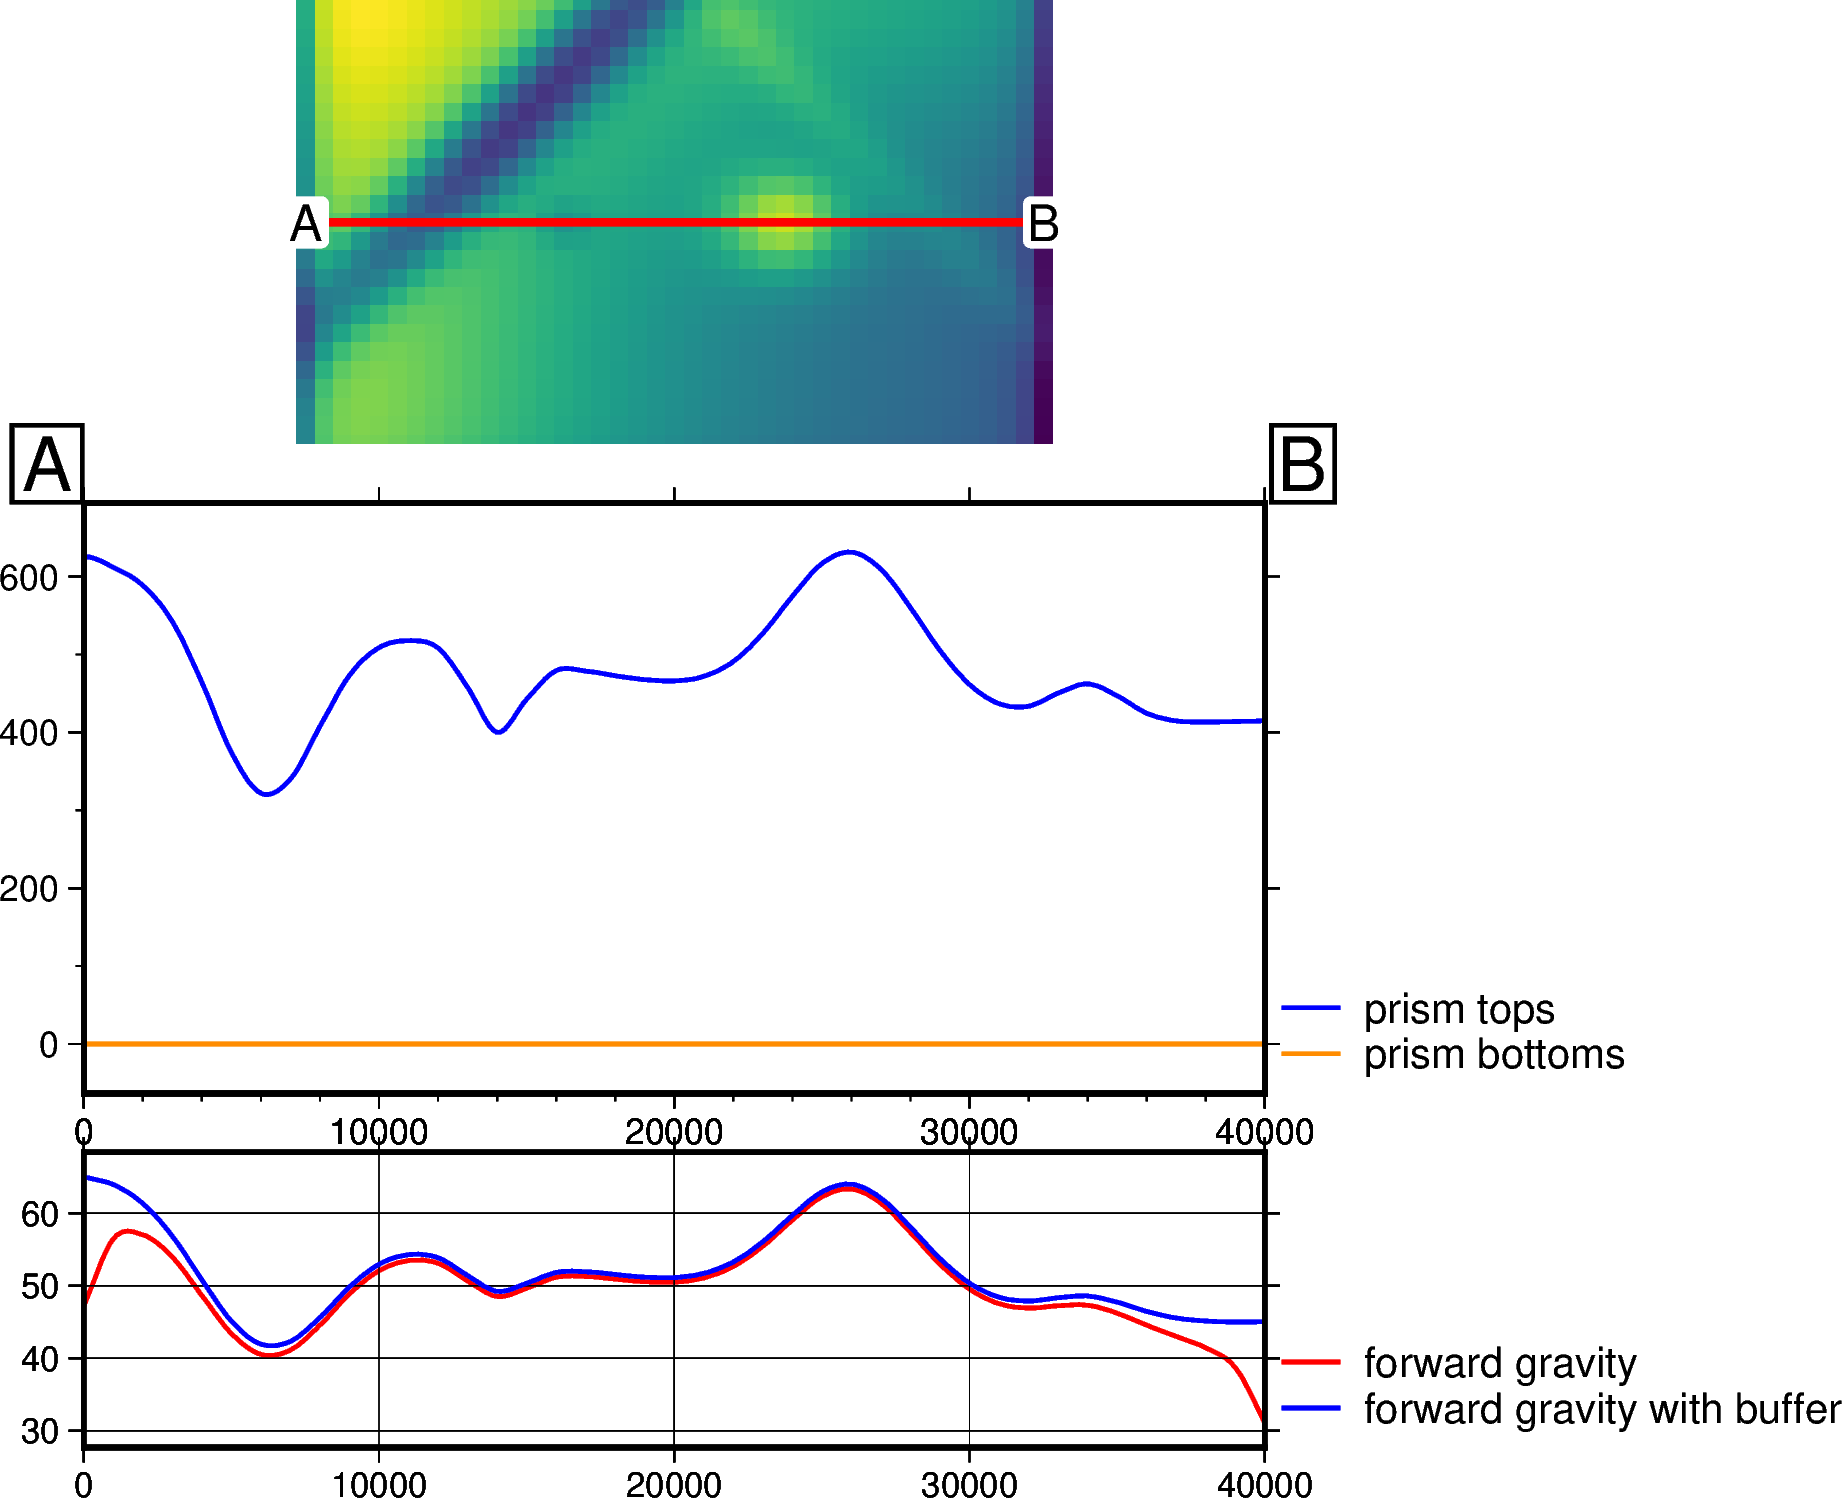

In [80]:
# plot profile across region
data_dict = profiles.make_data_dict(
    ["forward gravity", "forward gravity with buffer"],
    [grav_grid, grav_grid_buffer],
    ["red", "blue"],
)

layers_dict = profiles.make_data_dict(
    ["prism tops", "prism bottoms"],
    [prisms.top, prisms.bottom],
    ["blue", "darkorange"],
)

fig, _, _ = profiles.plot_profile(
    "points",
    add_map=True,
    map_background=grav_grid,
    subplot_orientation="vertical",
    coast=False,
    inset=False,
    gridlines=False,
    fig_width=10,
    fig_height=8,
    start=start,
    stop=stop,
    layers_dict=layers_dict,
    data_dict=data_dict,
    fill_layers=False,
)
fig.show()